## Import packages & Load data

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

DEBUG_DATA = False

## Define Genetic Regression Class

In [2]:
class GeneticRegression():
    # Initialization
    # Randomly generate initial population
    def __init__(self, num_population, mutation_rate, data_x, data_y):
        self.generation = 1
        self.n_pop = num_population
        self.mutation_rate = mutation_rate
        self.data_x = data_x
        self.data_y = data_y
        self.alpha = np.array(['%+011.6f' % val for val in np.random.uniform(-500, 500, self.n_pop)])
        self.bias = np.array(['%+011.6f' % val for val in np.random.uniform(-500, 500, self.n_pop)])
        self.loss_arr = []
        self.alpha_arr = []
        self.bias_arr = []
        self.count = 0
        pass

    def fit(self, stop_count):
        while self.count < stop_count:
            self.next_generation()
            pass
        pass
        
    def next_generation(self):
        if DEBUG_DATA:
            self.debugging(range(self.n_pop))
        self.selection()
        self.crossover()
        self.mutation()
        self.find_best()
        self.generation += 1
        pass
    
    # Selection
    def selection(self):
        if DEBUG_DATA: print('selection()', '_'*38,'\n')
        # Calculate the probability of selection for each element
        ratio = np.array([65535/self.MSE(self.query(i), self.data_y) for i in range(self.n_pop)])
        # Calculate cumulative distribution
        ratio = np.cumsum(ratio/np.sum(ratio))
        # Select element for next generation
        next_idx = [np.min(np.where(ratio > val)) for val in np.random.uniform(0, 1, self.n_pop)]
        # Selected alpha value via random number
        next_alpha = self.alpha[next_idx]
        # Selected bias value via random number
        next_bias = self.bias[next_idx]
        self.alpha = next_alpha
        self.bias = next_bias
        if DEBUG_DATA:
            print('Selected elements\n')
            self.debugging(next_idx)
        pass
    
    # Crossover
    def crossover(self):
        if DEBUG_DATA: print('crossover()', '_'*38,'\n')
        n = self.n_pop
        # Crossover one gene and another
        for i, j in zip(list(range(math.ceil(n/2+0.1)-1)), list(range(n-1, math.ceil(n/2)-1, -1))):
            if DEBUG_DATA: print('Recombinate element', i+1, 'and element',j+1)
            a1 = '%04d' % (np.int(self.alpha[i][:4]) + 1000)
            a2 = '%04d' % (np.int(self.alpha[j][:4]) + 1000)
            b1 = '%04d' % (np.int(self.bias[i][:4]) + 1000)
            b2 = '%04d' % (np.int(self.bias[j][:4]) + 1000)
            self.alpha[i] = '%+04d'%(np.int(a1[:2] + a2[2:]) - 1000) + self.alpha[i][4:]
            self.alpha[j] = '%+04d'%(np.int(a2[:2] + a1[2:]) - 1000) + self.alpha[j][4:]
            self.bias[i] = '%+04d'%(np.int(b1[:2] + b2[2:]) - 1000) + self.bias[i][4:]
            self.bias[j] = '%+04d'%(np.int(b2[:2] + b1[2:]) - 1000) + self.bias[j][4:]
            pass
        if DEBUG_DATA:
            print('\nrecombined elements', '\n')
            self.debugging(range(self.n_pop))
        pass
    
    # Mutation
    def mutation(self):
        if DEBUG_DATA: print('mutation()', '_'*39,'\n')
        n = self.n_pop
        for i in range(n):
            alpha_genes = np.array([int(gene) for gene in self.alpha[i][1:4] + self.alpha[i][5:]])
            alpha_mutate = np.random.uniform(-1, 1, 9)
            alpha_genes[alpha_mutate > 1 - self.mutation_rate] += 1
            alpha_genes[alpha_genes > 9] = 9
            alpha_genes[alpha_mutate < -1 + self.mutation_rate] -= 1
            alpha_genes[alpha_genes < 0] = 0
            
            bias_genes = np.array([int(gene) for gene in self.bias[i][1:4] + self.bias[i][5:]])
            bias_mutate = np.random.uniform(-1, 1, 9)
            bias_genes[bias_mutate > 1 - self.mutation_rate] += 1
            bias_genes[bias_genes > 9] = 9
            bias_genes[bias_mutate < -1 + self.mutation_rate] -= 1
            bias_genes[bias_genes < 0] = 0
            
            self.alpha[i] = self.alpha[i][0]
            for val in alpha_genes[:3]:
                self.alpha[i] += '%d'%val
                pass
            self.alpha[i] += '.'
            for val in alpha_genes[3:]:
                self.alpha[i] += '%d'%val
                
            self.bias[i] = self.bias[i][0]
            for val in bias_genes[:3]:
                self.bias[i] += '%d'%val
                pass
            self.bias[i] += '.'
            for val in bias_genes[3:]:
                self.bias[i] += '%d'%val
            pass
        
        if DEBUG_DATA:
            print('mutated elements', '\n')
            self.debugging(range(self.n_pop))
        pass
        
    def query(self, idx):
        return np.float(self.alpha[idx])*self.data_x+np.float(self.bias[idx])
    
    def MSE(self, y, t):
        return np.sum((t-y)**2)/y.shape[0]
    
    def find_best(self):
        mse_all = [self.MSE(self.query(i), self.data_y) for i in range(self.n_pop)]
        current_loss = np.min(mse_all)
        index = mse_all.index(current_loss)
        
        if self.count>0 and self.loss_arr[len(self.loss_arr)-1] <= current_loss:
            self.loss_arr.append(self.loss_arr[len(self.loss_arr)-1])
            self.alpha_arr.append(self.alpha_arr[len(self.alpha_arr)-1])
            self.bias_arr.append(self.bias_arr[len(self.bias_arr)-1])
            self.count += 1
        else:
            self.loss_arr.append(current_loss)
            self.alpha_arr.append(self.alpha[index])
            self.bias_arr.append(self.bias[index])
            self.count = 1
        pass
    
    def debugging(self, index):
        for i, val_a, val_b in zip(index, self.alpha, self.bias):
            print('[element', '%2d]'%(i+1), 'alpha:', val_a, 'bias:', val_b)
            pass
        print('_'*50, '\n')

In [3]:
def animate(i):
    global x, y, gr, axis
    x_line = np.linspace(axis[0], axis[1], 1000)
    y_line = x_line*np.float(gr.alpha_arr[i])+np.float(gr.bias_arr[i])
    line.set_data(x_line, y_line)
    plt.scatter(x, y, c='Red', s=5)
    plt.title('loss: %8.4f'%gr.loss_arr[i]+', alpha:'+gr.alpha_arr[i]+', bias'+gr.bias_arr[i])
    return (line,)

> ## Genetic Regression #1
> Randomly created train dataset for linear regression
> https://www.kaggle.com/andonians/random-linear-regression

In [4]:
population = 100
mutation_rate = 0.1
dataset = pd.read_csv(os.path.join('./input', 'RandomlyCreatedDatasetTrain.csv'))
stop = 10
x = dataset['x']
y = dataset['y']
axis = [-10, 110, -10, 110]

gr = GeneticRegression(population, mutation_rate,
                       x, y)
gr.fit(stop)

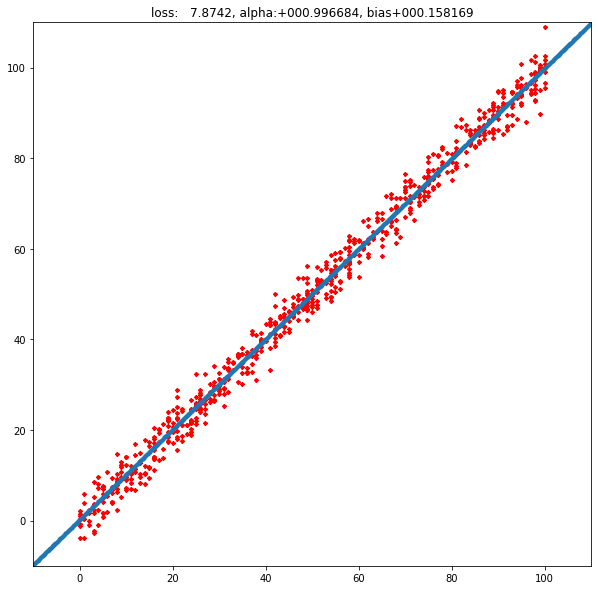

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
line, = ax.plot([], [], ".");
ax.set_xlim((axis[0], axis[1]))
ax.set_ylim((axis[2], axis[3]))

anim = animation.FuncAnimation(fig, animate, frames=gr.generation-1, interval=100, blit=True)
rc('animation', html='html5')
anim

> ## Genetic Regression #2
> Randomly created test dataset for linear regression
> https://www.kaggle.com/andonians/random-linear-regression

In [6]:
population = 100
mutation_rate = 0.1
dataset = pd.read_csv(os.path.join('./input', 'RandomlyCreatedDatasetTest.csv'))
stop = 10
x = dataset['x']
y = dataset['y']
axis = [-10, 110, -10, 110]

gr = GeneticRegression(population, mutation_rate, x, y)
gr.fit(stop)

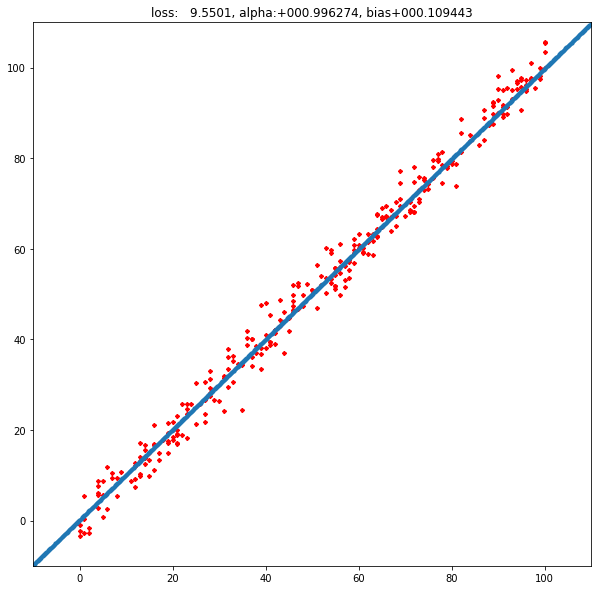

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
line, = ax.plot([], [], ".");
ax.set_xlim((axis[0], axis[1]))
ax.set_ylim((axis[2], axis[3]))

anim = animation.FuncAnimation(fig, animate, frames=gr.generation-1, interval=100, blit=True)
rc('animation', html='html5')
anim

> ## Genetic Regression #3
> 부산 금정구 어린이집 Dataset
> https://www.data.go.kr/data/15007684/fileData.do

In [18]:
population = 2000
mutation_rate = 0.1
dataset = pd.read_csv(os.path.join('./input', 'BusanDaycareCenter.csv'))
stop = 10
x = dataset['보육실 면적']
y = dataset['현원수']
axis = [0, np.max(dataset['보육실 면적'])+50, 0, np.max(dataset['현원수'])+20]

gr = GeneticRegression(population, mutation_rate, x, y)
gr.fit(stop)

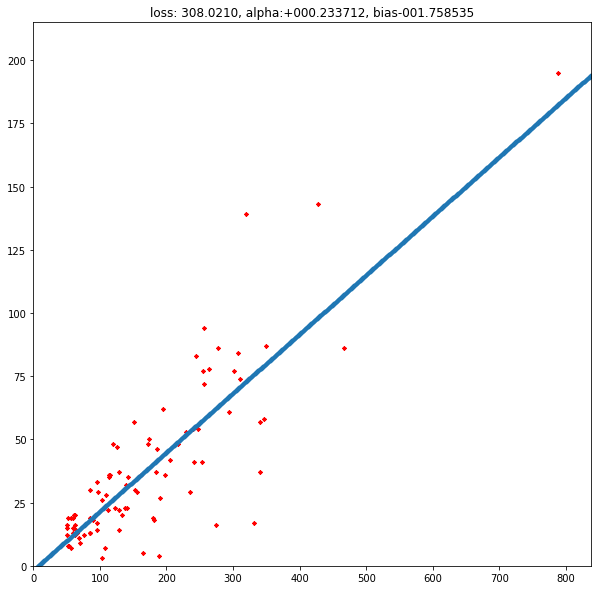

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
line, = ax.plot([], [], ".");
ax.set_xlim((axis[0], axis[1]))
ax.set_ylim((axis[2], axis[3]))

anim = animation.FuncAnimation(fig, animate, frames=gr.generation-1, interval=100, blit=True)
rc('animation', html='html5')
anim

> ## Genetic Regression #4
> 육군 신체측정정보 Dataset
> https://www.data.go.kr/data/3034732/fileData.do

In [51]:
population = 2000
mutation_rate = 0.25
dataset = pd.read_csv(os.path.join('./input', 'KoreanArmy.csv'))
stop = 10
x = dataset['신장 센티미터']
y = dataset['발 길이 센티미터']
x_min = np.min(dataset['신장 센티미터'])
x_max = np.max(dataset['신장 센티미터'])
y_min = np.min(dataset['발 길이 센티미터'])
y_max = np.max(dataset['발 길이 센티미터'])
axis = [x_min-10, x_max+10, y_min-10, y_max+10]

gr = GeneticRegression(population, mutation_rate, x, y)
gr.fit(stop)

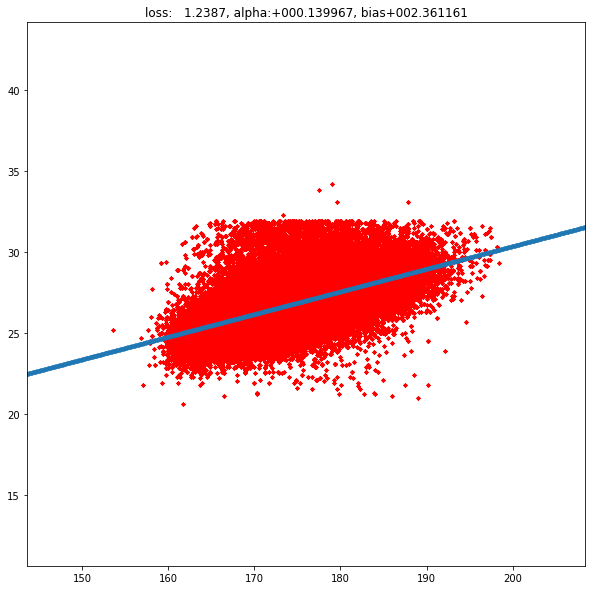

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
line, = ax.plot([], [], ".");
ax.set_xlim((axis[0], axis[1]))
ax.set_ylim((axis[2], axis[3]))

anim = animation.FuncAnimation(fig, animate, frames=gr.generation-1, interval=100, blit=True)
rc('animation', html='html5')
anim